In [1]:
!pip install python-whois

     |████████████████████████████████| 91 kB 197 kB/s eta 0:00:011
  Created wheel for python-whois: filename=python_whois-0.7.3-py3-none-any.whl size=87701 sha256=517fba3afeee0303eb68941d2df4d1bb100d3977ad2e8361d200a03b7c6cf838
  Stored in directory: /root/.cache/pip/wheels/11/05/f7/895ce5a73665f77c8274a7d55e34fb3e6b4abbb9a7637e215b
Successfully built python-whois
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import math
from collections import Counter
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import xgboost as xgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import socket
import whois
from datetime import datetime
import time
from bs4 import BeautifulSoup
import urllib
import bs4

/kaggle/input/malicious/malicious_phish.csv


In [4]:
df=pd.read_csv('/kaggle/input/malicious/malicious_phish.csv')

print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [5]:
df.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [6]:
import re
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [7]:
from urllib.parse import urlparse




def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [16]:
from googlesearch import search

In [17]:
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))

In [20]:
df['count.'] = df['url'].apply(lambda i: i.count('.'))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


In [21]:
df['count-www'] = df['url'].apply(lambda i: i.count('www'))
df['count@'] = df['url'].apply(lambda i: i.count('@'))
from urllib.parse import urlparse
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')
df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [22]:
df['count-https'] = df['url'].apply(lambda i : i.count('https'))
df['count-http'] = df['url'].apply(lambda i : i.count('http'))

In [23]:
df['count%'] = df['url'].apply(lambda i: i.count('%'))
df['count?'] = df['url'].apply(lambda i: i.count('?'))
df['count-'] = df['url'].apply(lambda i: i.count('-'))
df['count='] = df['url'].apply(lambda i: i.count('='))
#Length of URL
df['url_length'] = df['url'].apply(lambda i: len(str(i)))
#Hostname Length
df['hostname_length'] = df['url'].apply(lambda i: len(urlparse(i).netloc))

df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,count%,count?,count-,count=,url_length,hostname_length
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,0,0,0,0,0,1,0,16,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,0,0,0,0,0,0,0,35,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,0,0,0,0,0,0,0,31,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,0,0,1,0,1,1,4,88,21
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,0,0,1,0,1,1,3,235,23


In [24]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))

In [25]:
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,count%,count?,count-,count=,url_length,hostname_length,sus_url
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,0,0,0,0,0,1,0,16,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,0,0,0,0,0,0,0,35,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,0,0,0,0,0,0,0,31,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,0,0,1,0,1,1,4,88,21,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,0,0,1,0,1,1,3,235,23,0


In [26]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url'],
      dtype='object')

In [27]:
!pip install tld

     |████████████████████████████████| 329 kB 193 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [28]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [29]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
df['count-digits']= df['url'].apply(lambda i: digit_count(i))

In [30]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
df['count-letters']= df['url'].apply(lambda i: letter_count(i))

In [31]:
df = df.drop("tld",1)

In [32]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'fd_length', 'tld_length',
       'count-digits', 'count-letters'],
      dtype='object')

In [33]:
df['type'].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [34]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()



0    428103
1     96457
3     94111
2     32520
Name: type_code, dtype: int64

In [35]:
#Predictor Variables
X = df[['use_of_ip','abnormal_url', 'google_index', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']

In [36]:
X.head()

,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,1,2,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,0,0,1,2,0,0,2,0,0,0,...,0,0,0,35,0,0,5,-1,1,29
2,0,0,1,2,0,0,3,0,0,0,...,0,0,0,31,0,0,7,-1,1,25
3,0,1,1,3,1,0,1,0,0,0,...,1,1,4,88,21,0,9,2,7,63
4,0,1,1,2,0,0,1,0,0,0,...,1,1,3,235,23,0,9,3,22,199


In [37]:
X.columns

Index(['use_of_ip', 'abnormal_url', 'google_index', 'count.', 'count-www',
       'count@', 'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters'],
      dtype='object')

In [38]:
X.head()

,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,1,2,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,0,0,1,2,0,0,2,0,0,0,...,0,0,0,35,0,0,5,-1,1,29
2,0,0,1,2,0,0,3,0,0,0,...,0,0,0,31,0,0,7,-1,1,25
3,0,1,1,3,1,0,1,0,0,0,...,1,1,4,88,21,0,9,2,7,63
4,0,1,1,2,0,0,1,0,0,0,...,1,1,3,235,23,0,9,3,22,199


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

In [40]:
lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5, 
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)


y_pred = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred))

score = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     85621
           1       0.96      0.99      0.97     19292
           2       0.96      0.89      0.92      6504
           3       0.90      0.81      0.85     18822

    accuracy                           0.96    130239
   macro avg       0.95      0.92      0.93    130239
weighted avg       0.95      0.96      0.95    130239

accuracy:   0.956


In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Confusion matrix, without normalization


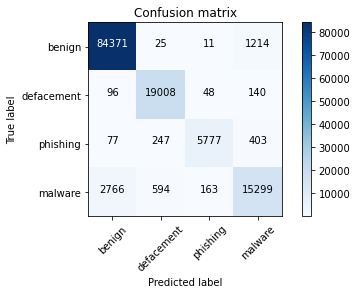

In [42]:
cm = metrics.confusion_matrix(y_test, y_pred, labels=[0,1,2,3])
plot_confusion_matrix(cm,classes=['benign', 'defacement','phishing','malware'])


In [43]:
lgb_feature = lgb.feature_importances_
lgb_feature

array([  31,   57,    0,  992,  529,   78, 1168,   41,  124,  310,  162,
        274,  191,  591,  445,  995, 1496,  299, 1765,  636, 1101,  715],
      dtype=int32)

In [44]:
model = xgb.XGBClassifier(n_estimators= 100)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))


score = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     85621
           1       0.97      0.99      0.98     19292
           2       0.98      0.92      0.94      6504
           3       0.91      0.83      0.87     18822

    accuracy                           0.96    130239
   macro avg       0.96      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.961


Confusion matrix, without normalization


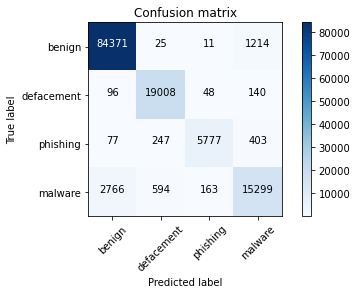

In [45]:
CM=confusion_matrix(y_test,y_pred,labels=[0,1,2,3])

plot_confusion_matrix(cm,classes=['benign', 'defacement','phishing','malware'])

In [46]:
gbdt = GradientBoostingClassifier(n_estimators=100,max_features='sqrt')
gbdt.fit(X_train,y_train)
y_pred = gbdt.predict(X_test)
print(classification_report(y_test,y_pred))

score = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     85621
           1       0.90      0.97      0.93     19292
           2       0.93      0.79      0.85      6504
           3       0.88      0.73      0.80     18822

    accuracy                           0.94    130239
   macro avg       0.92      0.87      0.89    130239
weighted avg       0.93      0.94      0.93    130239

accuracy:   0.936


Confusion matrix, without normalization


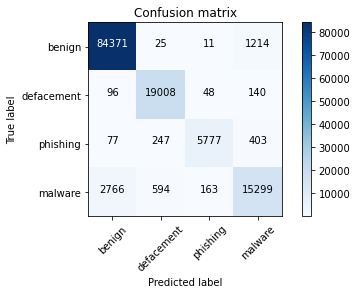

In [47]:
CM=confusion_matrix(y_test,y_pred,labels=[0,1,2,3])

plot_confusion_matrix(cm,classes=['benign', 'defacement','phishing','malware'])

In [56]:
gbdt_feature = gbdt.feature_importances_
gbdt_feature

array([0.01422164, 0.05206413, 0.        , 0.02868465, 0.13249984,
       0.00071255, 0.12090048, 0.00017663, 0.0003583 , 0.02346279,
       0.09642648, 0.00730826, 0.01089888, 0.02327172, 0.06502678,
       0.04349845, 0.15375502, 0.0091799 , 0.03902921, 0.1139888 ,
       0.02779176, 0.03674371])

In [57]:
xgb_feature = model.feature_importances_
xgb_feature

array([0.18995441, 0.00864374, 0.        , 0.01276796, 0.12045407,
       0.01123682, 0.0595661 , 0.00428362, 0.0046364 , 0.05147118,
       0.1236386 , 0.02176145, 0.00992822, 0.02163003, 0.01570353,
       0.0258724 , 0.08584396, 0.0270134 , 0.01704087, 0.16727157,
       0.01070208, 0.01057967], dtype=float32)

In [58]:
lgb_features = [  31,   57,    0,  992,  529,   78, 1168,   41,  124,  310,  162,
        274,  191,  591,  445,  995, 1496,  299, 1765,  636, 1101,  715]

xgb_features = [0.18995441, 0.00864374, 0.        , 0.01276796, 0.12045407,
       0.01123682, 0.0595661 , 0.00428362, 0.0046364 , 0.05147118,
       0.1236386 , 0.02176145, 0.00992822, 0.02163003, 0.01570353,
       0.0258724 , 0.08584396, 0.0270134 , 0.01704087, 0.16727157,
       0.01070208, 0.01057967]

gbdt_features = [0.01422164, 0.05206413, 0.        , 0.02868465, 0.13249984,
       0.00071255, 0.12090048, 0.00017663, 0.0003583 , 0.02346279,
       0.09642648, 0.00730826, 0.01089888, 0.02327172, 0.06502678,
       0.04349845, 0.15375502, 0.0091799 , 0.03902921, 0.1139888 ,
       0.02779176, 0.03674371]

In [59]:
cols = X_train.columns
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
    
    'Gradient Boost feature importances': gbdt_features,
    'XG Boost feature importances': xgb_features,
    'LGBM feature importances': lgb_features
                                   
    })
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

ValueError: arrays must all be same length

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
def plot_feature_importance():
    tmp = pd.DataFrame({'Feature': X_test.columns, 'Feature importance': feature_dataframe['mean'].values})
    tmp = tmp.sort_values(by='Feature importance',ascending=False).head(20)
    plt.figure(figsize = (10,12))
    plt.title('Average Feature Importance Top 20 Features',fontsize=14)
    s = sns.barplot(y='Feature',x='Feature importance',data=tmp, orient='h')
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()
plot_feature_importance()